# SMRF Evaluation

In [1]:
%load_ext chime

import os
import re
from glob import glob
import pandas as pd
import geopandas as gpd
import rasterio as rio
import numpy as np
import pdal
from rasterio.windows import from_bounds, transform
from rasterio.fill import fillnodata
from skll.metrics import kappa

from joblib import Parallel, delayed
from datetime import datetime
import re

from skll.metrics import correlation
from sklearn.metrics import *

from importnb import Notebook

1. Loop through SMRF DTMs
1. Pull Parameters from file name
1. Read in SMRF Raster
1. Get Mask from No Data Values
1. Get Window of raster extent
1. Read in 2015 DEM from Window
1. Read in 10m Slope at relative resolution
1. Read in DTG at relative resolution
1. Double check check array shapes
1. Create empty arrays to hold raster names, slope values, dtg values, nodata count, and kappa number
1. For each category of Slope and DTG
    1. Create new mask from slope and dtg
    1. Mask no data mask, mask DEM, mask DTM
    1. Get Count of NoData Mask
    1. Get Kappa Number for difference between the two masked arrays
    1. Append kappa, nodata, etc to new empty arrays
1. Create pandas DF from various arrays
1. Return Pandas DF

In [2]:
# 1. Loop through SMRF DTMs
loc_dem_2015 = "/mnt/PAG2015Elev/EPC_DEM_2015.vrt"
if not os.path.exists(loc_dem_2015):
    loc_dem_2015 = "D:/EPC_DEM_2015.vrt"
loc_dtg = "../EPCExtent_30cm/Elevation_80cmNPS/HAG_NED_80cm_DTG/EPC_HAGNEDDTG80cm_2019.vrt"
loc_slope = "../OtherData/10mDEMs/DEM10mNED_slope.tif"
loc_dtm = "../EPCExtent_30cm/Elevation_80cmNPS/DTM80cm/"
dtm_tifs = glob(loc_dtm+"/Sc*/*.tif")

loc_stats_df = './CompletedStatsEvaluations.csv'

slope_breaks = [5,15,25]
dtg_breaks = [25,50,100,200]

slope_categories = {}
for si, slope_break in enumerate(slope_breaks):
    slope_min = slope_breaks[si-1] if si-1 >= 0 else 0
    slope_max = slope_breaks[si] if si+1 < len(slope_breaks) else 90
    slope_categories[slope_break] = {'Min':slope_min, 'Max':slope_max}

dtg_categories = {}
for di, dtg_break in enumerate(dtg_breaks):
    dtg_min = dtg_breaks[di-1] if di-1 >= 0 else 0
    dtg_max = dtg_breaks[di] if di+1 < len(dtg_breaks) else 20000
    dtg_categories[dtg_break] = {'Min':dtg_min, 'Max':dtg_max}
    
    
def getStatsDF(dtm_file, writeOutput=False):
    # 2. Pull Parameters from file name
    fname = os.path.basename(dtm_file)
    params = fname.split("_")[-1].replace(".tif","")
    
    param_list = re.split('[a-zA-z]+',params)
    scalar_param = param_list[1]
    slope_param = param_list[2]
    threshold_param = param_list[3]
    winSize_param = param_list[4]
    
    # 3. Read in SMRF Raster
    with rio.open(dtm_file) as src:
        kwargs = src.profile
        smrf = src.read(1)
        nd_value = src.nodata
        # 4. Get Mask from No Data Values
        smrf_mask = smrf != nd_value
        # 5 Get window of raster extent
        bnds = src.bounds
    
    with rio.open(loc_dem_2015) as src:
        #6. Read in 2015 DEM from Window
        dem = src.read(1, window=from_bounds(bnds.left, bnds.bottom, bnds.right, bnds.top, transform=src.transform), out_shape=(smrf.shape))

    # 7. Read in 10m Slope at relative resolution
    with rio.open(loc_slope) as src:
        slope = src.read(1, window=from_bounds(bnds.left, bnds.bottom, bnds.right, bnds.top, transform=src.transform), out_shape=(smrf.shape))
        
    # 8. Read in DTG at relative resolution
    with rio.open(loc_dtg) as src:
        dtg = src.read(1, window=from_bounds(bnds.left, bnds.bottom, bnds.right, bnds.top, transform=src.transform), out_shape=(smrf.shape))
        
    # 9. Double check check array shapes
    if not smrf.shape == dtg.shape == slope.shape == dem.shape:
        print("Bad Shapes")
        return None
        
    # 10. Create empty arrays to hold raster names, slope values, dtg values, nodata count, and kappa number
    slope_values = []
    dtg_values = []
    valid_counts = []
    possibleCount = []
    sumErrors = []
    sumError2s = []
    
    # 11. For each category of Slope and DTG
    for sv, stolerances in slope_categories.items():
        for dv, dtolerances in dtg_categories.items():
            
            outfile_2015 = f"{fname[:-4]}2015_Sl{sv}DTG{dv}.tif"
            outfile_2019 = f"{fname[:-4]}2019_Sl{sv}DTG{dv}.tif"
            file_2015 = os.path.join("./temp", outfile_2015)
            file_2019 = os.path.join("./temp", outfile_2019)
            
            
            # 11a Create new mask from slope and dtg
            slope_mask = (slope >= stolerances['Min']) & (slope < stolerances['Max'])
            dtg_mask =   (dtg   >= dtolerances['Min']) & (dtg   < dtolerances['Max'])
            categoryMask = (dtg_mask==True) & (slope_mask==True)
            
            # 11b Mask no data mask, mask DEM, mask DTM
            all_mask = (dtg_mask==True) & (slope_mask==True) & (smrf_mask==True)
            
            if writeOutput and (not os.path.exists(file_2015) or not os.path.exists(file_2019)):
                dem_out = np.where(all_mask == True, dem, -9999)
                smrf_out = np.where(all_mask == True, smrf, -9999)
                
                kwargs.update(nodata=-9999, dtype=np.float32)

                with rio.open(file_2015, 'w', **kwargs) as dst:
                    dst.write(dem_out.astype(np.float32),1)
                with rio.open(file_2019, 'w', **kwargs) as dst:
                    dst.write(smrf_out.astype(np.float32),1)


            # 11c Mask SMRF and DTM
            dem_valid = dem[all_mask==True]
            smrf_valid = smrf[all_mask==True]
            #print(len(dem_valid), len(smrf_valid))
            
            error = np.absolute(dem_valid-smrf_valid)
            error_2 = error**2
            
            # Get Count of non-masked data
            vc = len(error)
            
            pc = len(categoryMask[categoryMask==True])
            
            # Get sum of absolute error values
            se = error.sum()
            # Get sum of absolute error values
            se2 = error_2.sum()
            
            
            # 11c Append slope value, dtg value, counts, sum error and sum error squared, to new empty arrays
            slope_values.append(stolerances['Max'])
            dtg_values.append(dtolerances['Max'])
            valid_counts.append(vc)
            possibleCount.append(pc)
            sumErrors.append(se)
            sumError2s.append(se2)

    raster_name = [fname] * len(valid_counts)
    scalar_params = [scalar_param] * len(valid_counts)
    slope_params = [slope_param] * len(valid_counts)
    threshold_params = [threshold_param] * len(valid_counts)
    winSize_params = [winSize_param] * len(valid_counts)
    
    d = {'DTMRaster': raster_name,
         "Slope_Max": slope_values,
         "DTG_Max": dtg_values,
         "Scalar_Param" : scalar_params,
         "Slope_Param": slope_params,
         "Threshold_Param": threshold_params,
         "WindowSize_Param": winSize_params,
         "Valid_Count": valid_counts,
         "PossibleCount": possibleCount,
         "SumError": sumErrors,
         "SumError2": sumError2s}
    
    df = pd.DataFrame(data=d)
    
    return df



In [3]:
def getToDo(dtm_files, csv_location = './CompletedStatsEvaluations.csv'):
    data_frames = []
    to_do_files = []

    if os.path.exists(csv_location):
        print("csv exists")
        stats_df = pd.read_csv(csv_location)
        data_frames.append(stats_df)

        files_done = set(stats_df['DTMRaster'].to_list())
    else:
        files_done = []

    for dtm in dtm_files:
        if os.path.basename(dtm) not in files_done:
            to_do_files.append(dtm)

    print(f"{len(to_do_files)} remaining to process")
    
    
    return to_do_files, data_frames

#### TEST FUNCTIONS

In [4]:
to_do_tifs, dfs = getToDo(dtm_tifs, csv_location = loc_stats_df)

csv exists
0 remaining to process


In [63]:
to_do_tifs, dfs = getToDo(dtm_tifs, csv_location = loc_stats_df)

batch_size = 1000
while len(to_do_tifs)>0 and batch_size >= 1:
    print(f"Starting with Batch Size set to {batch_size}")
    for i in range(0, len(to_do_tifs), batch_size):
        batch = to_do_tifs[i:i + batch_size]
        print(f"{datetime.now()}  -  Starting {i}-{i+batch_size-1} of {len(to_do_tifs)}")
        try:
            new_dfs = Parallel(n_jobs=10, verbose=5, backend="loky")(delayed(getStatsDF)(dtm) for dtm in batch)
            dfs += new_dfs
            stats_df = pd.concat(dfs)
            stats_df.to_csv(loc_stats_df, index=False)
        except:
            print(f"Issue with batch starting at {i}")

    batch_size = int(batch_size/10) if batch_size != 1 else 0
    to_do_tifs, dfs = getToDo(dtm_tifs, csv_location = loc_stats_df)
else:
    print(f"{len(to_do_tifs)} unable to be processed")
    for t in to_do_tifs:
        print(os.path.abspath(t))

csv exists
0 remaining to process
0 unable to be processed


___________________________________
# Evalute Dataframe of results

### Need to compute the number of possible valid values (number of cells within the slope and dtg categories) to compare to the valid count and weigh the error calculations

In [10]:
stats_df = pd.read_csv("CompletedStatsEvaluations.csv")
for col in stats_df.columns.tolist():
    if "Unnamed: " in col:
        del stats_df[col]
print(f"{len(stats_df)} rows")
stats_df.head()

373759 rows


,DTMRaster,Slope_Max,DTG_Max,Scalar_Param,Slope_Param,Threshold_Param,WindowSize_Param,Valid_Count,PossibleCount,SumError,SumError2
0,E0860_N370_9_Sc0.25Sl0.001Th0.1WS100.tif,5,25,0.25,0.001,0.1,100,2133604,6987092,1.516580e+06,1.544572e+06
1,E0860_N370_9_Sc0.25Sl0.001Th0.1WS100.tif,5,50,0.25,0.001,0.1,100,587,988,4.147541e+03,2.983581e+04
2,E0860_N370_9_Sc0.25Sl0.001Th0.1WS100.tif,5,100,0.25,0.001,0.1,100,24,61,1.613757e+02,1.085622e+03
3,E0860_N370_9_Sc0.25Sl0.001Th0.1WS100.tif,5,20000,0.25,0.001,0.1,100,0,0,0.000000e+00,0.000000e+00
4,E0860_N370_9_Sc0.25Sl0.001Th0.1WS100.tif,15,25,0.25,0.001,0.1,100,3588,7835,1.245064e+04,8.017887e+04


In [11]:
stats_df = stats_df[stats_df.DTMRaster.str.contains("E1080_N430")].copy()
print(len(stats_df))

6612


In [12]:
# Drop rows without any valid values
stats_df = stats_df[stats_df.Valid_Count > 0]
print(f"{len(stats_df)} rows")

# Parse sub-tile name
stats_df["subTileName"] = stats_df['DTMRaster'].apply(lambda f: "_".join(f.split("_")[:3]))
print(f"{len(stats_df['subTileName'].unique())} sub-tiles evaluated")

5402 rows
2 sub-tiles evaluated


In [13]:
#stats_df = pd.read_csv(loc_stats_df)
display(stats_df.head())

# Re-establish parameter values in case inputs were changed above
slope_values = stats_df['Slope_Param'].value_counts().keys().tolist()
scalar_values = stats_df['Scalar_Param'].value_counts().keys().tolist()
threshold_values = stats_df['Threshold_Param'].value_counts().keys().tolist()
window_values = stats_df['WindowSize_Param'].value_counts().keys().tolist()
slope_values.sort()
scalar_values.sort()
threshold_values.sort()
window_values.sort()

,DTMRaster,Slope_Max,DTG_Max,Scalar_Param,Slope_Param,Threshold_Param,WindowSize_Param,Valid_Count,PossibleCount,SumError,SumError2,subTileName
888,E1080_N430_4_Sc0.25Sl0.001Th0.1WS100.tif,5,25,0.25,0.001,0.1,100,697275,1455376,7.677394e+05,1.327562e+06,E1080_N430_4
889,E1080_N430_4_Sc0.25Sl0.001Th0.1WS100.tif,5,50,0.25,0.001,0.1,100,813,969,1.240766e+03,3.001875e+03,E1080_N430_4
890,E1080_N430_4_Sc0.25Sl0.001Th0.1WS100.tif,5,100,0.25,0.001,0.1,100,2,2,1.515281e+00,1.149327e+00,E1080_N430_4
892,E1080_N430_4_Sc0.25Sl0.001Th0.1WS100.tif,15,25,0.25,0.001,0.1,100,2926858,4601396,5.089808e+06,1.273384e+07,E1080_N430_4
893,E1080_N430_4_Sc0.25Sl0.001Th0.1WS100.tif,15,50,0.25,0.001,0.1,100,51758,70650,8.238946e+04,1.896394e+05,E1080_N430_4


In [14]:
stats_df_grp = stats_df.groupby(by = ["DTG_Max","Slope_Max", "Slope_Param", "Scalar_Param", "Threshold_Param", "WindowSize_Param"]).agg(
        {"SumError":"sum", "SumError2":"sum","Valid_Count":"sum", "PossibleCount":"sum"})
stats_df_grp

SumError  \
DTG_Max Slope_Max Slope_Param Scalar_Param Threshold_Param WindowSize_Param                  
25      5         0.001       0.0          0.10            25                909818.716007   
                                                           100               751064.811653   
                                                           200               532418.377141   
                                           0.25            25                945122.028291   
                                                           100               789725.972082   
...                                                                                    ...   
20000   90        0.250       3.0          1.50            100                   46.202344   
                                                           200                   86.996435   
                                           3.00            25                    75.941588   
                                                           100                   46.202344   
                                                           200                   86.996435   

                                                                                SumError2  \
DTG_Max Slope_Max Slope_Param Scalar_Param Threshold_Param WindowSize_Param                 
25      5         0.001       0.0          0.10            25                1.317575e+06   
                                                           100               1.301297e+06   
                                                           200               8.841021e+05   
                                           0.25            25                1.358251e+06   
                                                           100               1.357320e+06   
...                                                                                   ...   
20000   90        0.250       3.0          1.50            100               5.608466e+01   
                                                           200               1.702321e+02   
                                           3.00            25                1.322696e+02   
                                                           100               5.608466e+01   
                                                           200               1.702321e+02   

                                                                             Valid_Count  \
DTG_Max Slope_Max Slope_Param Scalar_Param Threshold_Param WindowSize_Param                
25      5         0.001       0.0          0.10            25                    1036682   
                                                           100                    679317   
                                                           200                    535484   
                                           0.25            25                    1094347   
                                                           100                    729059   
...                                                                                  ...   
20000   90        0.250       3.0          1.50            100                        48   
                                                           200                        48   
                                           3.00            25                         48   
                                                           100                        48   
                                                           200                        48   

                                                                             PossibleCount  
DTG_Max Slope_Max Slope_Param Scalar_Param Threshold_Param WindowSize_Param                 
25      5         0.001       0.0          0.10            25                      1400887  
                                                           100                     1455376  
                                                           200                  

### Calculate MAE and RMSE

In [15]:
stats_df_grp['MAE'] = stats_df_grp.apply(lambda r: r.SumError/r.Valid_Count, axis=1)
stats_df_grp['RMSE']= stats_df_grp.apply(lambda r: np.sqrt(r.SumError2/r.Valid_Count), axis=1)

#Calculate percentage of area classified as ground
stats_df_grp["PercGround"] = np.round(stats_df_grp.Valid_Count/stats_df_grp.PossibleCount,4)
print(round(stats_df_grp["PercGround"].mean(),4), stats_df_grp["PercGround"].median())
stats_df_grp.head(10)

0.9154 0.9923


SumError  \
DTG_Max Slope_Max Slope_Param Scalar_Param Threshold_Param WindowSize_Param                 
25      5         0.001       0.0          0.10            25                9.098187e+05   
                                                           100               7.510648e+05   
                                                           200               5.324184e+05   
                                           0.25            25                9.451220e+05   
                                                           100               7.897260e+05   
                                                           200               5.651612e+05   
                                           0.50            25                9.822113e+05   
                                                           100               8.320825e+05   
                                                           200               6.022673e+05   
                                           1.00            25                1.037591e+06   

                                                                                SumError2  \
DTG_Max Slope_Max Slope_Param Scalar_Param Threshold_Param WindowSize_Param                 
25      5         0.001       0.0          0.10            25                1.317575e+06   
                                                           100               1.301297e+06   
                                                           200               8.841021e+05   
                                           0.25            25                1.358251e+06   
                                                           100               1.357320e+06   
                                                           200               9.348472e+05   
                                           0.50            25                1.394288e+06   
                                                           100               1.413091e+06   
                                                           200               9.896272e+05   
                                           1.00            25                1.446674e+06   

                                                                             Valid_Count  \
DTG_Max Slope_Max Slope_Param Scalar_Param Threshold_Param WindowSize_Param                
25      5         0.001       0.0          0.10            25                    1036682   
                                                           100                    679317   
                                                           200                    535484   
                                           0.25            25                    1094347   
                                                           100                    729059   
                                                           200                    576990   
                                           0.50            25                    1163181   
                                                           100                    788796   
                                                           200                    626947   
                                           1.00            25                    1252941   

                                                                             PossibleCount  \
DTG_Max Slope_Max Slope_Param Scalar_Param Threshold_Param WindowSize_Param                  
25      5         0.001       0.0          0.10            25                      1400887   
                                                           100                     1455376   
                                                           200                     1529169   
                                           0.25            25                      1400887   
                                                           100                     1455376   
                                                           200                     1

In [16]:
#np.percentile(stats_df_grp_reset.PercGround,60), stats_df_grp_reset.PercGround.median()
#for group,row in stats_df_grp_reset.groupby(by = ["DTG_Max","Slope_Max"]):
#    for slope in slope_values:
#        stats_df_grp_reset.plot(x="Slope_Param",y="RMSE")
    #stats_df_grp_reset[stats_df_grp_reset.Slope_Param == value][['Slope'.hist()

In [17]:
stats_df_grp_reset = stats_df_grp.reset_index(level=['Slope_Param', 'Scalar_Param','Threshold_Param', 'WindowSize_Param'])

best_fits = []
worst_fits = []

#for stat in ['MAE', 'RMSE']:
def getMinimumGroupOfStat(df, stat):
    stat_best_fits = []
    stat_worst_fits = []
    
    for name, group in df.groupby(by=['DTG_Max','Slope_Max']):
        #pgcig = group['Valid_Count'].sum()/group['PossibleCount'].sum()
        #print(f"Percentage Ground Classified in Group: {round(pgcig,3)}")
        print(f'Group: {name} - Median: {round(group["PercGround"].median(),3)}, 55th Percentile: {round(np.percentile(group.PercGround,55),3)}')
        bestGroup = group[group["PercGround"] >= group["PercGround"].median()]
        best_fit = bestGroup[bestGroup[stat] == bestGroup[stat].min()].copy()
        worst_fit = bestGroup[bestGroup[stat] == bestGroup[stat].max()].copy()

        best_fit.rename(columns={stat:stat+"_min"}, inplace=True)
        worst_fit.rename(columns={stat:stat+"_min"}, inplace=True)
        stat_best_fits.append(best_fit)
        stat_worst_fits.append(worst_fit)

    stat_best_fits = pd.concat(stat_best_fits)
    stat_best_fits['Stat'] = stat
    
    stat_worst_fits = pd.concat(stat_worst_fits)
    stat_worst_fits['Stat'] = stat
    
    return stat_best_fits.reset_index()

mae_best_fits = getMinimumGroupOfStat(stats_df_grp_reset, 'MAE')
rmse_best_fits = getMinimumGroupOfStat(stats_df_grp_reset, 'RMSE')

print(f"STATISTIC: Mean Absolute Error (MAE)")
display(mae_best_fits)
print(f"STATISTIC: Root Mean Squared Error (RMSE)")
display(rmse_best_fits)

Group: (25, 5) - Median: 0.912, 55th Percentile: 0.951
Group: (25, 15) - Median: 0.953, 55th Percentile: 0.97
Group: (25, 90) - Median: 0.966, 55th Percentile: 0.977
Group: (50, 5) - Median: 0.976, 55th Percentile: 0.988
Group: (50, 15) - Median: 0.984, 55th Percentile: 0.992
Group: (50, 90) - Median: 0.977, 55th Percentile: 0.986
Group: (100, 5) - Median: 1.0, 55th Percentile: 1.0
Group: (100, 15) - Median: 0.971, 55th Percentile: 0.984
Group: (100, 90) - Median: 0.96, 55th Percentile: 0.981
Group: (20000, 90) - Median: 1.0, 55th Percentile: 1.0
Group: (25, 5) - Median: 0.912, 55th Percentile: 0.951
Group: (25, 15) - Median: 0.953, 55th Percentile: 0.97
Group: (25, 90) - Median: 0.966, 55th Percentile: 0.977
Group: (50, 5) - Median: 0.976, 55th Percentile: 0.988
Group: (50, 15) - Median: 0.984, 55th Percentile: 0.992
Group: (50, 90) - Median: 0.977, 55th Percentile: 0.986
Group: (100, 5) - Median: 1.0, 55th Percentile: 1.0
Group: (100, 15) - Median: 0.971, 55th Percentile: 0.984
Group

,DTG_Max,Slope_Max,Slope_Param,Scalar_Param,Threshold_Param,WindowSize_Param,SumError,SumError2,Valid_Count,PossibleCount,MAE_min,RMSE,PercGround,Stat
0,25,5,0.010,0.00,1.00,25,1.072655e+06,1.488973e+06,1300726,1400887,0.824659,1.069918,0.9285,MAE
1,25,15,0.010,0.00,1.50,25,5.804929e+06,1.224022e+07,4319788,4464410,1.343800,1.683307,0.9676,MAE
2,25,90,0.001,1.50,3.00,25,2.003136e+06,8.608407e+06,854444,867580,2.344373,3.174093,0.9849,MAE
3,50,5,0.250,0.00,0.10,100,1.421288e+03,3.524822e+03,969,969,1.466757,1.907246,1.0000,MAE
4,50,15,0.100,0.00,0.10,25,9.023443e+04,1.866287e+05,68132,68203,1.324406,1.655060,0.9990,MAE
5,50,90,0.010,0.00,1.50,25,8.841924e+04,2.769132e+05,48569,49630,1.820487,2.387769,0.9786,MAE
6,100,5,0.005,0.00,0.25,200,1.197597e+00,7.184137e-01,2,2,0.598799,0.599339,1.0000,MAE
7,100,5,0.005,0.50,0.10,200,1.197597e+00,7.184137e-01,2,2,0.598799,0.599339,1.0000,MAE
8,100,15,0.100,0.00,0.10,100,8.723157e+03,1.689336e+04,6592,6605,1.323294,1.600846,0.9980,MAE
9,100,90,0.100,0.25,0.10,100,1.854643e+04,4.932138e+04,11328,11363,1.637220,2.086609,0.9969,MAE


STATISTIC: Root Mean Squared Error (RMSE)


,DTG_Max,Slope_Max,Slope_Param,Scalar_Param,Threshold_Param,WindowSize_Param,SumError,SumError2,Valid_Count,PossibleCount,MAE,RMSE_min,PercGround,Stat
0,25,5,0.010,0.50,1.00,25,1.078402e+06,1.495940e+06,1306965,1400887,0.825119,1.069855,0.9330,RMSE
1,25,15,0.001,0.00,3.00,25,5.907834e+06,1.242584e+07,4391345,4464410,1.345336,1.682147,0.9836,RMSE
2,25,90,0.250,3.00,3.00,25,2.037823e+06,8.673127e+06,867408,867580,2.349325,3.162104,0.9998,RMSE
3,50,5,0.250,0.00,0.10,100,1.421288e+03,3.524822e+03,969,969,1.466757,1.907246,1.0000,RMSE
4,50,15,0.100,0.00,0.10,25,9.023443e+04,1.866287e+05,68132,68203,1.324406,1.655060,0.9990,RMSE
5,50,90,0.001,1.50,3.00,25,8.975209e+04,2.779397e+05,49129,49630,1.826866,2.378517,0.9899,RMSE
6,100,5,0.005,0.00,0.25,200,1.197597e+00,7.184137e-01,2,2,0.598799,0.599339,1.0000,RMSE
7,100,5,0.005,0.50,0.10,200,1.197597e+00,7.184137e-01,2,2,0.598799,0.599339,1.0000,RMSE
8,100,15,0.100,0.00,0.10,100,8.723157e+03,1.689336e+04,6592,6605,1.323294,1.600846,0.9980,RMSE
9,100,90,0.100,0.25,0.10,100,1.854643e+04,4.932138e+04,11328,11363,1.637220,2.086609,0.9969,RMSE


In [18]:
%matplotlib inline
#stats_df_grp_reset[['Slope_Param','RMSE']].plot(x="Slope_Param")
stats_df_grp_reset.groupby(['DTG_Max','Slope_Max'])['RMSE'].mean().unstack('DTG_Max')#.plot.bar()

DTG_Max,25,50,100,20000
Slope_Max,,,,
5,1.203365,2.076519,0.951882,NaN
15,1.871463,1.767028,1.759676,NaN
90,3.435384,2.496432,2.170590,1.447207


#### OLDER RMSE AND MAE BEST FIT CALC THAT DID NOT USE A MEDIAN OR PERCENTAGE CUTOFF

stats_df_grp_reset = stats_df_grp.reset_index(level=['Slope_Param', 'Scalar_Param','Threshold_Param', 'WindowSize_Param'])

best_fits = []
worst_fits = []

#for stat in ['MAE', 'RMSE']:
def getMinimumGroupOfStat(df, stat):
    stat_best_fits = []
    stat_worst_fits = []
    
    for name, group in df.groupby(by=['DTG_Max','Slope_Max']):
        perGroundMedian = group[group["PercGround"]].median()
        best_fit = group[(group[stat] == group[stat].min()) & (group["PercGround"] >= perGroundMedian)].copy()
        worst_fit = group[group[stat] == group[stat].max()].copy()

        best_fit.rename(columns={stat:stat+"_min"}, inplace=True)
        worst_fit.rename(columns={stat:stat+"_min"}, inplace=True)
        stat_best_fits.append(best_fit)
        stat_worst_fits.append(worst_fit)

    stat_best_fits = pd.concat(stat_best_fits)
    stat_best_fits['Stat'] = stat
    
    stat_worst_fits = pd.concat(stat_worst_fits)
    stat_worst_fits['Stat'] = stat
    
    return stat_best_fits.reset_index()

mae_best_fits = getMinimumGroupOfStat(stats_df_grp_reset, 'MAE')
rmse_best_fits = getMinimumGroupOfStat(stats_df_grp_reset, 'RMSE')

print(f"STATISTIC: Mean Absolute Error (MAE)")
display(mae_best_fits)
print(f"STATISTIC: Root Mean Squared Error (RMSE)")
display(rmse_best_fits)

In [74]:
#stats_df_grp_reset.head(20)

In [19]:
t = stats_df_grp_reset.groupby(by = ["DTG_Max","Slope_Max"]).agg({"Valid_Count":"sum","PossibleCount":"sum"}).reset_index().sort_values(by="PossibleCount")
t["PercGround"] = np.round(t.Valid_Count/t.PossibleCount,4)
t

,DTG_Max,Slope_Max,Valid_Count,PossibleCount,PercGround
6,100,5,1254,1254,1.0000
9,20000,90,22059,22464,0.9820
3,50,5,513913,557001,0.9226
7,100,15,3230410,3550680,0.9098
8,100,90,5555366,6368379,0.8723
5,50,90,25332440,28198010,0.8984
4,50,15,34934377,38390878,0.9100
2,25,90,444517781,487848847,0.9112
0,25,5,707515454,834204848,0.8481
1,25,15,2216284442,2525161412,0.8777


In [19]:
# Write Evaluate to Output Files
day_date = 20201001
mae_out = f"MAEEvaluation_{day_date}.csv"
rmse_out = f"RMSEEvaluation_{day_date}.csv"
if not os.path.exists(mae_out):
    print(f"Writing out MAE Evaluation Results to {mae_out}")
    mae_best_fits.to_csv(mae_out, index=False)
if not os.path.exists(rmse_out):
    print(f"Writing out RMSE Evaluation Results to {rmse_out}")
    rmse_best_fits.to_csv(rmse_out, index=False)

In [20]:
bf_compare = pd.merge(mae_best_fits, rmse_best_fits[['DTG_Max', 'Slope_Max', 'RMSE_min']], left_on=['DTG_Max','Slope_Max'], right_on=['DTG_Max','Slope_Max'])
rows_w_param_discrepancies = bf_compare[bf_compare.RMSE != bf_compare.RMSE_min][['DTG_Max','Slope_Max','MAE_min', 'RMSE_min']]
#display(rows_w_mae_rmse_discrepancies)
for i,row in rows_w_param_discrepancies.iterrows():
    rmse_params = rmse_best_fits[(rmse_best_fits.DTG_Max == row.DTG_Max) & (rmse_best_fits.Slope_Max == row.Slope_Max)][['Slope_Param', 'Scalar_Param','Threshold_Param', 'WindowSize_Param', 'RMSE_min']]
    rmse_params['Stat'] = 'RMSE'
    print(f"\nBest Parameter Difference for DTG Max of {row.DTG_Max} and Slope Max of {row.Slope_Max}")
    mae_params = mae_best_fits[(mae_best_fits.DTG_Max == row.DTG_Max) & (mae_best_fits.Slope_Max == row.Slope_Max)][['Slope_Param', 'Scalar_Param','Threshold_Param', 'WindowSize_Param', 'MAE_min']]
    
    mae_params['Stat'] = 'MAE'
    stat_comp = pd.concat([rmse_params, mae_params])
    
    mae_value_for_best_rmse = stats_df_grp_reset[stats_df_grp_reset['RMSE'] == row.RMSE_min]['MAE'].values[0]
    mae_diff = abs(row.MAE_min-mae_value_for_best_rmse)
    print(f"Difference in MAE for best parameters evalued against RMSE and MAE:  {mae_diff}")
    
    rmse_value_for_best_rmse = stats_df_grp_reset[stats_df_grp_reset['MAE'] == row.MAE_min]['MAE'].values[0]
    rmse_diff = abs(row.RMSE_min-rmse_value_for_best_rmse)
    print(f"Difference in RMSE for best parameters evalued against RMSE and MAE: {rmse_diff}")
    display(stat_comp)


Best Parameter Difference for DTG Max of 25.0 and Slope Max of 5.0
Difference in MAE for best parameters evalued against RMSE and MAE:  0.0004604022947127806
Difference in RMSE for best parameters evalued against RMSE and MAE: 0.2451965226893349


,Slope_Param,Scalar_Param,Threshold_Param,WindowSize_Param,RMSE_min,Stat,MAE_min
0,0.01,0.5,1.0,25,1.069855,RMSE,NaN
0,0.01,0.0,1.0,25,NaN,MAE,0.824659



Best Parameter Difference for DTG Max of 25.0 and Slope Max of 15.0
Difference in MAE for best parameters evalued against RMSE and MAE:  0.0015364446727623715
Difference in RMSE for best parameters evalued against RMSE and MAE: 0.338347830801762


,Slope_Param,Scalar_Param,Threshold_Param,WindowSize_Param,RMSE_min,Stat,MAE_min
1,0.001,0.0,3.0,25,1.682147,RMSE,NaN
1,0.010,0.0,1.5,25,NaN,MAE,1.3438



Best Parameter Difference for DTG Max of 25.0 and Slope Max of 90.0
Difference in MAE for best parameters evalued against RMSE and MAE:  0.004951800248065297
Difference in RMSE for best parameters evalued against RMSE and MAE: 0.8177309472569627


,Slope_Param,Scalar_Param,Threshold_Param,WindowSize_Param,RMSE_min,Stat,MAE_min
2,0.250,3.0,3.0,25,3.162104,RMSE,NaN
2,0.001,1.5,3.0,25,NaN,MAE,2.344373



Best Parameter Difference for DTG Max of 50.0 and Slope Max of 90.0
Difference in MAE for best parameters evalued against RMSE and MAE:  0.0063786581484224225
Difference in RMSE for best parameters evalued against RMSE and MAE: 0.5580301501438873


,Slope_Param,Scalar_Param,Threshold_Param,WindowSize_Param,RMSE_min,Stat,MAE_min
5,0.001,1.5,3.0,25,2.378517,RMSE,NaN
5,0.010,0.0,1.5,25,NaN,MAE,1.820487


In [21]:
# Using MAE for Evaluations...
num_min_slopes = len(mae_best_fits[mae_best_fits.Slope_Param == min(slope_values)])
if num_min_slopes > 0 and min(slope_values) != 0:
    print(f"Num with minimum slope value of {min(slope_values)} : {num_min_slopes}")

num_min_scalars = len(mae_best_fits[mae_best_fits.Threshold_Param == min(scalar_values)])
if num_min_scalars > 0 and min(scalar_values) != 0:
    print(f"Num with minimum scalar of {min(scalar_values)} : {um_min_scalars}")
    
num_min_threshold = len(mae_best_fits[mae_best_fits.Threshold_Param == min(threshold_values)])
if num_min_threshold > 0 and min(threshold_values) != 0:
    print(f"Num with minimum threshold value of {min(threshold_values)} : {num_min_threshold}")


num_max_slopes = len(mae_best_fits[mae_best_fits.Slope_Param == max(slope_values)])
if num_max_slopes > 0 and max(slope_values) != 90:
    print(f"Num with maximum slope value of {max(slope_values)} : {num_max_slopes}")

num_max_scalars = len(mae_best_fits[mae_best_fits.Threshold_Param == max(scalar_values)])
if num_max_scalars > 0:
    print(f"Num with maximum scalar value of {max(scalar_values)} : {num_max_scalars}")
    
num_max_threshold = len(mae_best_fits[mae_best_fits.Threshold_Param == max(threshold_values)])
if num_max_threshold > 0:
    print(f"Num with maximum threshold value of {max(threshold_values)} : {num_max_threshold}")

Num with minimum slope value of 0.001 : 1
Num with minimum threshold value of 0.1 : 6
Num with maximum slope value of 0.25 : 1
Num with maximum scalar value of 3.0 : 1
Num with maximum threshold value of 3.0 : 1


### Create Outputs

#### Create dataframe of dtm files with parameters broken out

In [23]:
loc_dtm = r"../EPCExtent_30cm/Elevation_80cmNPS/DTM80cm/"
loc_slope = "../OtherData/10mDEMs/DEM10mNED_slope.tif"
loc_dtg = "../EPCExtent_30cm/Elevation_80cmNPS/HAG_NED_80cm_DTG/EPC_HAGNEDDTG80cm_2019.vrt"

slope_breaks = [5,15,25]
dtg_breaks = [25,50,100,200]

slope_categories = {}
for si, slope_break in enumerate(slope_breaks):
    slope_min = slope_breaks[si-1] if si-1 >= 0 else 0
    slope_max = slope_breaks[si] if si+1 < len(slope_breaks) else 90
    slope_categories[slope_break] = {'Min':slope_min, 'Max':slope_max}

dtg_categories = {}
for di, dtg_break in enumerate(dtg_breaks):
    dtg_min = dtg_breaks[di-1] if di-1 >= 0 else 0
    dtg_max = dtg_breaks[di] if di+1 < len(dtg_breaks) else 20000
    dtg_categories[dtg_break] = {'Min':dtg_min, 'Max':dtg_max}


dtm_tifs = glob(loc_dtm+"/Sc*/*.tif")
dtm_tifs = [f for f in dtm_tifs if "DTM80cm_Finals" not in f]
files_df = pd.DataFrame.from_dict({"filePath":dtm_tifs})
files_df['file'] = files_df["filePath"].apply(lambda f: os.path.basename(f))
param_names = ["Scalar_Param","Slope_Param","Threshold_Param","WindowSize_Param"]
for pn in param_names:
    files_df[pn] = None
    
#files_df['len'] = files_df.apply(lambda r: re.split('[a-zA-z]+',r['file'].split("_")[3].replace(".tif","")),axis=1)
files_df[param_names] = files_df.apply(lambda r: pd.Series(re.split('[a-zA-z]+',r['file'].split("_")[3].replace(".tif",""))[1:]),axis=1)
for pn in param_names:
    files_df[pn] = pd.to_numeric(files_df[pn])

files_df['subtile'] = files_df.file.apply(lambda f: "_".join(f.split("_")[:3]))
files_df.head()

rmse_best_fits = pd.read_csv(f"RMSEEvaluation_20201001.csv")

In [81]:
#t = stats_df_grp_reset.reset_index()
#t = t[(t.DTG_Max == 100) & (t.Slope_Max==5) & (t.Slope_Param == 0.001) & (t.Scalar_Param == 0.00) & (t.Threshold_Param == 0.1)]
#t

In [82]:
#relevant_files = pd.merge(files_df, rmse_best_fits, how='right', on=param_names)
#relevant_files.head()

#### Get unique parameters values from RMSE best fits

In [24]:
rmse_slope_vals = rmse_best_fits.Slope_Param.unique()
rmse_scalar_vals = rmse_best_fits.Scalar_Param.unique()
rmse_thres_vals = rmse_best_fits.Threshold_Param.unique()
rmse_ws_vals = rmse_best_fits.WindowSize_Param.unique()

relevantFiles_df = files_df[(files_df.Scalar_Param.isin(rmse_scalar_vals)) &
             (files_df.Slope_Param.isin(rmse_slope_vals)) &
             (files_df.Threshold_Param.isin(rmse_thres_vals)) &
             (files_df.WindowSize_Param.isin(rmse_ws_vals))
            ]

#### Read in subtile samples and combine

In [4]:
pd.set_option('max_colwidth', 1000)

subTileIndex_loc = "../EPCExtent_30cm/Elevation_80cmNPS/subTileIndex.gpkg"
allSubTiles = gpd.read_file(subTileIndex_loc)

centralTucsonSample_loc = "../EPCExtent_30cm/Elevation_80cmNPS/centralTucson_sample.gpkg"
subTileSample_loc = "../EPCExtent_30cm/Elevation_80cmNPS/subTileSample.gpkg"

centralTucsonSample = gpd.read_file(centralTucsonSample_loc)
del centralTucsonSample['quads']
subTileSample = gpd.read_file(subTileSample_loc)

# Combine samples
allSampleSubTiles = pd.concat([subTileSample, centralTucsonSample])
allSampleSubTiles['subtile'] = allSampleSubTiles.apply(lambda r: os.path.basename(r.originFile).replace(".laz","") + "_" + str(r.subIndex), axis=1)


In [5]:
# Read in all Sub-tiles
allSubTiles['subtile'] = allSubTiles.apply(lambda r: os.path.basename(r.originFile).replace(".laz","") + "_" + str(r.subIndex), axis=1)

In [20]:
def createDTM(tileRow, paramsRow, resolution, dtmfolder, overwrite=False):        
    """Create DTM File From SMRF Params"""
    infile = tileRow.originFile
    fname = os.path.basename(infile)
    #suffix = f"Sc{params['scalar']}Sl{params['slope']}Th{params['threshold']}WS{params['win_size']}"
    
    # do this to convert values to int if they don't loose precision (e.g. 100.0 to 100)
    scalar = int(paramsRow['Scalar_Param']) if paramsRow['Scalar_Param'] ==  int(paramsRow['Scalar_Param']) else paramsRow['Scalar_Param']
    slope = int(paramsRow['Slope_Param']) if paramsRow['Slope_Param'] ==  int(paramsRow['Slope_Param']) else paramsRow['Slope_Param']
    threshold = int(paramsRow['Threshold_Param']) if paramsRow['Threshold_Param'] ==  int(paramsRow['Threshold_Param']) else paramsRow['Threshold_Param']
    windowsize = int(paramsRow['WindowSize_Param']) if paramsRow['WindowSize_Param'] ==  int(paramsRow['WindowSize_Param']) else paramsRow['WindowSize_Param']
    
    # need to set limit on windows size. 
    suffix = f"Sc{scalar}Sl{slope}Th{threshold}WS{windowsize}"
    
    out_DTMFolder = os.path.join(dtmfolder,suffix)
    os.makedirs(out_DTMFolder, exist_ok=True)

    outtiff = os.path.join(out_DTMFolder, fname.replace(".laz", f"_{tileRow.subIndex}_{suffix}.tif"))
    
    # Create tif if it doesn't exist
    if not os.path.exists(outtiff) or overwrite:
        print(f"{datetime.now()}\t-\tStarted creating {os.path.basename(outtiff)} - File Exists: {os.path.exists(outtiff)}, Overwrite: {overwrite}")
        filterSMRF = """
        {
            "type": "filters.smrf",
            "returns":"first,last,intermediate,only",
            "cell":%s,
            "scalar": %s,
            "slope": %s,
            "threshold": %s,
            "window": %s     
        }"""

        geom = tileRow.geometry.buffer(paramsRow['WindowSize_Param'])
        xmin,ymin,xmax,ymax = geom.bounds
    
        pipeline_json = """ "%s" """ % infile
        pipeline_json += ',' + filterCrop % (xmin,xmax,ymin,ymax)
        pipeline_json += ',' + filterSMRF % (resolution, paramsRow['Scalar_Param'], paramsRow['Slope_Param'], paramsRow['Threshold_Param'], paramsRow['WindowSize_Param'])
        #pipeline_json += ',' + filterPMF % (8, 0.15, 40, 50, 1.5)
        pipeline_json += ',' + filterGround
        #pipeline_json += ',' + writeLAZ % (outlaz)
        pipeline_json += ',' + writeTIFF % (outtiff, resolution, 0)
        
        pipeline_json = json_pipe_base % pipeline_json.replace("\\","/")
        with open("../EPCExtent_30cm/Elevation_80cmNPS/DTM80cm/DTM80cm_Finals/pipe.json", 'w+') as of:
            of.write(pipeline_json)
            
        pipeline = pdal.Pipeline(pipeline_json)
        pipeline.loglevel = 8

        start = datetime.now()
        #try:
        pipeline.execute()
        #except:
        #    print(f"Failed for {outtiff}")
        end = datetime.now()

        print(f"{datetime.now()}\t-\tFinished creating {os.path.basename(outtiff)} - {end-start} elapsed")
    
    
    return (tileRow.geometry.bounds, outtiff)

def mergeTiffs(tile_geoms_and_tiffs, out_dir):
    """Mask and combine SMRF-created DTMs based on SMRF Params and estimate slope and distance to ground (dtg)"""
    
    masked_arrays = []
    for tile in tile_geoms_and_tiffs:
        xmin,ymin,xmax,ymax = tile[0]
        tiff = tile[1]
        file_params = os.path.basename(tiff).split("_")[3].replace(".tif","")
        param_list = [float(i) for i in re.split('[a-zA-z]+',file_params)[1:5]]
        #print(param_list)
        sc = param_list[0]
        sl = param_list[1]
        th = param_list[2]
        ws = param_list[3]
        valid_rows = rmse_best_fits[(rmse_best_fits.Scalar_Param == sc) &
                                    (rmse_best_fits.Slope_Param == sl) &
                                    (rmse_best_fits.Threshold_Param == th) &
                                    (rmse_best_fits.WindowSize_Param == ws)
                                   ]
        #print(tiff)
        #display(valid_rows)
        #print(tiff, valid_rows.DTG_Max.values)
        
        #print(f"Tile Bounds: {tile[0]}")

        with rio.open(tiff) as src:
            kwargs = src.profile
            #print(kwargs)
            rasbnds = src.bounds
            
            raswidth = rasbnds.right -rasbnds.left
            tilewidth = xmax-xmin
            tileheight = ymax-ymin
            #print("Ras Width:", raswidth, "Tile Width", tilewidth)
            # Get full window of raster extent
            read_window = from_bounds(xmin, ymin, xmax, ymax, transform=src.transform)
            out_transform = transform(read_window, src.transform)
            smrf = src.read(1, window=read_window)#, out_shape=(tilewidth,tileheight))
            #print("Read in shape", smrf.shape)
            #smrf = src.read(1, window=from_bounds(bl, bb, br, bt, transform=src.transform))
            #print(smrf.shape)
            #print((xmax-xmin)/src.res[0])

            nd_value = src.nodata
            # 4. Get Mask from No Data Values
            smrf_mask = smrf != nd_value
                    
        for i, row in valid_rows.iterrows():
            # Read in 10m Slope at relative resolution
            with rio.open(loc_slope) as src:
                slope = src.read(1, window=from_bounds(xmin, ymin, xmax, ymax, transform=src.transform), out_shape=(smrf.shape))

            # Read in DTG at relative resolution
            with rio.open(loc_dtg) as src:
                dtg = src.read(1, window=from_bounds(xmin, ymin, xmax, ymax, transform=src.transform), out_shape=(smrf.shape))

            dtg_val = [k for k, v in dtg_categories.items() if v['Max'] == row.DTG_Max][0]
            slope_val = [k for k, v in slope_categories.items() if v['Max'] == row.Slope_Max][0]
            
            # Create new mask from slope and dtg
            slope_mask = (slope >= slope_categories[slope_val]['Min']) & (slope < slope_categories[slope_val]['Max'])
            
            # need to set a true limit on dtg if max value is read as 20000. Max winow size is 500, so there won't be any valid values greater than the window size
            dtg_max = dtg_categories[dtg_val]['Max']
            dtg_max = dtg_max if dtg_max < (ws-20) else ws-20
            dtg_mask   = (dtg >= dtg_categories[dtg_val]['Min']) & (dtg < dtg_categories[dtg_val]['Max'])
            
            # Mask no data mask, mask DEM, mask DTM
            all_categories_mask = (dtg_mask==True) & (slope_mask==True) & (smrf_mask==True)
            num_valid = len(all_categories_mask[all_categories_mask])
            
            if num_valid > 0:
                masked_data = np.where(all_categories_mask == True, smrf, np.NaN)
                masked_arrays.append(masked_data)
            #else:
            #    print(f"no valid for {valid_rows}")
            
    # Stack and average
    meanstack = np.nanmean(masked_arrays, axis=0)
    #return masked_arrays
    # Fill holes (non-ground)
    #mean_stack_fill = fillAllNoData(meanstack)

    # Write out the file
    ofile_name = "_".join(os.path.basename(tiff).split("_")[:3]) + ".tif"
    ofile = os.path.join(out_dir, ofile_name)
    kwargs.update(
        width= smrf.shape[0],
        height= smrf.shape[1],
        transform= out_transform
    )
    #print(kwargs)
    with rio.open(ofile, 'w', **kwargs, ) as dst:
        dst.write(meanstack, 1)
    
    return ofile


def fillAllNoData(array):
    nan_count = len(array[np.isnan(array)])
    if nan_count == 0:
        print("No data to fill")
        return array
    
    msk = np.isnan(array)
    filled = fillnodata(array, mask=~msk, max_search_distance=500, smoothing_iterations=2)
    while len(array[np.isnan(array)]) > 0:
        #print("Found unfilled pixels. Re-filling")
        msk = np.isnan(filled)
        filled = fillnodata(array, mask=~msk, max_search_distance=500, smoothing_iterations=2)
    return filled

#masked_dtms = mergeTiffs(param_tiffs)
#print(np.nanmax(t[1]))

In [21]:
#from skimage.restoration import inpaint
#inpaint.inpaint_biharmonic(image_defect, mask)

11 unique combos for RMSE best fits
Working E1020_N470_7
2020-11-19 12:28:01.686361 Starting on 59 of 2934 - E1020_N470_7


<ipython-input-20-ee01c090ad5c>:143: RuntimeWarning: Mean of empty slice
  meanstack = np.nanmean(masked_arrays, axis=0)


/mnt/Bertha/PAG2019/EPCExtent_30cm/Elevation_80cmNPS/DTM80cm/DTM80cm_Finals/E1020_N470_7.tif


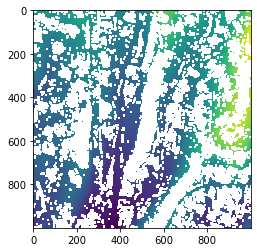

In [22]:
from skimage.restoration import inpaint

rmse_params_uniqueSets = rmse_best_fits[param_names].drop_duplicates(subset=param_names).sort_values('Slope_Param').reset_index()
print(f"{len(rmse_params_uniqueSets)} unique combos for RMSE best fits")
res = round(0.8/0.3048,5)
dtm_folder = os.path.abspath(r"../EPCExtent_30cm/Elevation_80cmNPS/DTM80cm")

allSubTiles.originFile = allSubTiles.originFile.apply(lambda f: f.replace("/media/ben/Bertha/PAG2019",".."))
subTileSample.originFile = subTileSample.originFile.apply(lambda f: f.replace("/media/ben/Bertha/PAG2019",".."))

json_pipe_base = """ { "pipeline": [ %s ] } """
filterCrop = """
    {
        "type":"filters.crop",
        "bounds":"([%s, %s],[%s, %s])",
        "a_srs":"EPSG:2868"   
    }"""
filterGround = """
    {
        "type":"filters.range",
        "limits":"Classification[2:2]"
    }"""
writeTIFF = """
    {
        "type":"writers.gdal",
        "filename": "%s",
        "resolution": %s,
        "window_size": %s,
        "nodata": 0,
        "output_type": "idw",
        "gdalopts":"TILED=YES, COMPRESS=LZW"
    }"""
#/media/ben/Bertha/PAG2019/EPCExtent_30cm/Elevation_80cmNPS/RGB/Full/E1020_N470.laz
target_tile = "E1020_N470"
totalTiles = len(allSubTiles)
for i, tilerow in subTileSample.iterrows():
    if target_tile not in tilerow.subtile:
        continue
    
    print(f"Working {tilerow.subtile}")
    t1 = datetime.now()
    print(f"{t1} Starting on {i} of {totalTiles} - {tilerow.subtile}")

    #param_tiffs_w_geom = Parallel(n_jobs=5, verbose=0, backend="loky")(delayed(
    #        createDTM)(tilerow, paramrow, res, dtm_folder, overwrite=False) for pi, paramrow in rmse_params_uniqueSets.iterrows())
    param_tiffs_w_geom = []
    for pi, paramrow in rmse_params_uniqueSets.iterrows():
        param_tiffs_w_geom.append(createDTM(tilerow, paramrow, res, dtm_folder, overwrite=False))
    
    odir = "../EPCExtent_30cm/Elevation_80cmNPS/DTM80cm/DTM80cm_Finals"
    os.makedirs(odir, exist_ok=True)
    final_dtm = mergeTiffs(param_tiffs_w_geom, odir)
    
    with rio.open(final_dtm) as src:
        t = src.read(1)

    break
    
from rasterio.plot import show
print(os.path.abspath(final_dtm))
show(t[500:1500, 500:1500])

In [28]:
for i  in param_tiffs_w_geom:
    print(i[1])

/mnt/Bertha/PAG2019/EPCExtent_30cm/Elevation_80cmNPS/DTM80cm/Sc0Sl0.005Th1.5WS100/E1020_N470_7_Sc0Sl0.005Th1.5WS100.tif
/mnt/Bertha/PAG2019/EPCExtent_30cm/Elevation_80cmNPS/DTM80cm/Sc0Sl0.01Th1.5WS200/E1020_N470_7_Sc0Sl0.01Th1.5WS200.tif
/mnt/Bertha/PAG2019/EPCExtent_30cm/Elevation_80cmNPS/DTM80cm/Sc0Sl0.01Th1.5WS100/E1020_N470_7_Sc0Sl0.01Th1.5WS100.tif
/mnt/Bertha/PAG2019/EPCExtent_30cm/Elevation_80cmNPS/DTM80cm/Sc0Sl0.01Th1WS100/E1020_N470_7_Sc0Sl0.01Th1WS100.tif
/mnt/Bertha/PAG2019/EPCExtent_30cm/Elevation_80cmNPS/DTM80cm/Sc3Sl0.01Th0.1WS100/E1020_N470_7_Sc3Sl0.01Th0.1WS100.tif
/mnt/Bertha/PAG2019/EPCExtent_30cm/Elevation_80cmNPS/DTM80cm/Sc1Sl0.01Th0.25WS100/E1020_N470_7_Sc1Sl0.01Th0.25WS100.tif
/mnt/Bertha/PAG2019/EPCExtent_30cm/Elevation_80cmNPS/DTM80cm/Sc3Sl0.01Th1.5WS200/E1020_N470_7_Sc3Sl0.01Th1.5WS200.tif
/mnt/Bertha/PAG2019/EPCExtent_30cm/Elevation_80cmNPS/DTM80cm/Sc0Sl0.1Th0.1WS200/E1020_N470_7_Sc0Sl0.1Th0.1WS200.tif
/mnt/Bertha/PAG2019/EPCExtent_30cm/Elevation_80cmNPS/DTM80

In [39]:
rmse_best_fits.query("Slope_Max == 15 & DTG_Max == 25")

,DTG_Max,Slope_Max,Slope_Param,Scalar_Param,Threshold_Param,WindowSize_Param,SumError,SumError2,Valid_Count,PossibleCount,MAE,RMSE_min,PercGround,Stat
1,25,15,0.01,0.0,1.5,100,1.210961e+08,3.239185e+08,74235604,88843434,1.631241,2.088872,0.8356,RMSE


<ipython-input-27-8919a9664187>:79: RuntimeWarning: Mean of empty slice
  meanstack = np.nanmean(masked_arrays, axis=0)


/mnt/Bertha/PAG2019/EPCExtent_30cm/Elevation_80cmNPS/DTM80cm/Sc0Sl0.005Th1.5WS100/E1060_N450_3_Sc0Sl0.005Th1.5WS100.tif
/mnt/Bertha/PAG2019/EPCExtent_30cm/Elevation_80cmNPS/DTM80cm/Sc0Sl0.01Th1.5WS200/E1060_N450_3_Sc0Sl0.01Th1.5WS200.tif
/mnt/Bertha/PAG2019/EPCExtent_30cm/Elevation_80cmNPS/DTM80cm/Sc0Sl0.01Th1.5WS100/E1060_N450_3_Sc0Sl0.01Th1.5WS100.tif
/mnt/Bertha/PAG2019/EPCExtent_30cm/Elevation_80cmNPS/DTM80cm/Sc0Sl0.01Th1WS100/E1060_N450_3_Sc0Sl0.01Th1WS100.tif
/mnt/Bertha/PAG2019/EPCExtent_30cm/Elevation_80cmNPS/DTM80cm/Sc3Sl0.01Th0.1WS100/E1060_N450_3_Sc3Sl0.01Th0.1WS100.tif
/mnt/Bertha/PAG2019/EPCExtent_30cm/Elevation_80cmNPS/DTM80cm/Sc1Sl0.01Th0.25WS100/E1060_N450_3_Sc1Sl0.01Th0.25WS100.tif
/mnt/Bertha/PAG2019/EPCExtent_30cm/Elevation_80cmNPS/DTM80cm/Sc3Sl0.01Th1.5WS200/E1060_N450_3_Sc3Sl0.01Th1.5WS200.tif
/mnt/Bertha/PAG2019/EPCExtent_30cm/Elevation_80cmNPS/DTM80cm/Sc0Sl0.1Th0.1WS200/E1060_N450_3_Sc0Sl0.1Th0.1WS200.tif
/mnt/Bertha/PAG2019/EPCExtent_30cm/Elevation_80cmNPS/DTM80

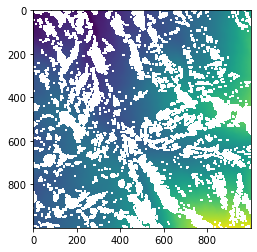

In [38]:
#param_tiffs_w_geom = Parallel(n_jobs=5, verbose=0, backend="loky")(delayed(
#            createDTM)(tilerow, paramrow, res, dtm_folder, overwrite=True) for pi, paramrow in rmse_params_uniqueSets.iterrows())

param_tiffs_w_geom = []
for pi, paramrow in rmse_params_uniqueSets.iterrows():
    param_tiffs_w_geom.append(createDTM(tilerow, paramrow, res, dtm_folder, overwrite=False))
final_dtm = mergeTiffs(param_tiffs_w_geom, odir)

for i, p in param_tiffs_w_geom:
    print(os.path.abspath(p))
    
from rasterio.plot import show
#oras = mergeTiffs(param_tiffs_w_geom, odir)
with rio.open(final_dtm) as src:
    t = src.read(1)
    
show(t[500:1500, 500:1500])

In [86]:
#final_dtm = mergeTiffs(param_tiffs_w_geom, odir)
#np.nanmean(final_dtm, axis=0)

In [39]:
final_dtm

'../EPCExtent_30cm/Elevation_80cmNPS/DTM80cm/DTM80cm_Finals/E1060_N450_3.tif'

In [604]:
masked_dtmsopen(param_tiffs[0].replace(".tif",".json")) as dst:
    content = dst.readlines()

In [625]:
with rio.open(param_tiffs[0]) as src:
    data = src.read(window=from_bounds(xmin,ymin,xmax,ymax, transform=src.transform))
    bnds = src.bounds
    res = src.res
    print(data.shape)

(1, 2645, 2645)


In [702]:
stack = np.stack(masked_dtms)
meanstack = np.nanmean(stack, axis=0)
print(np.nanmean(meanstack))
print(np.nanmean(stack))


2815.065031458118
2815.065031458119


<ipython-input-702-24dfb82b76c1>:2: RuntimeWarning: Mean of empty slice
  meanstack = np.nanmean(stack, axis=0)


295619

In [675]:
len(glob("../EPCExtent_30cm/Elevation_80cmNPS/DTM80cm/*/*.tif"))

29160

In [576]:
widths = []
heights = []
for i, row in allSubTiles.iterrows():
    minx, miny, maxx, maxy = row.geometry.bounds
    widths.append(round(maxy-miny,2))
    heights.append(round(maxx-minx,2))
set(widths), set(heights)

({6839.96}, {6839.96})

In [609]:
tilebnds = allSubTiles[allSubTiles.subtile == "E0860_N370_9"].geometry.values[0].bounds
print(tilebnds[2] - tilebnds[0])
tilebnds = allSubTiles.iloc[50].geometry.bounds
print(tilebnds[2] - tilebnds[0])

6839.956666666665
6839.959999999963


In [600]:
for i in param_tiffs:
    with rio.open(i) as src:
        bnds = src.bounds
        print(bnds)
        print(src.width, bnds.right-bnds.left)#, src.height, src.res[1])
    #break

BoundingBox(left=873319.53, bottom=363280.14, right=880261.78215, top=370222.39215)
2645 6942.252149999957
BoundingBox(left=873219.53, bottom=363180.13, right=880261.5196100001, top=370222.11961)
2683 7041.989610000048
BoundingBox(left=873219.53, bottom=363180.13, right=880261.5196100001, top=370222.11961)
2683 7041.989610000048
BoundingBox(left=873219.53, bottom=363180.13, right=880261.5196100001, top=370222.11961)
2683 7041.989610000048
BoundingBox(left=873219.53, bottom=363180.13, right=880261.5196100001, top=370222.11961)
2683 7041.989610000048
BoundingBox(left=873219.53, bottom=363180.13, right=880261.5196100001, top=370222.11961)
2683 7041.989610000048


In [537]:
dtg_categories

{25: {'Min': 0, 'Max': 25},
 50: {'Min': 25, 'Max': 50},
 100: {'Min': 50, 'Max': 100},
 200: {'Min': 100, 'Max': 20000}}

In [485]:
loc_dtg = "/mnt/Bertha/PAG2019/EPCExtent_30cm/Elevation_80cmNPS/HAG_NED_80cm_DTG/EPC_HAGNEDDTG80cm_2019.vrt"
loc_slope = "/mnt/Bertha/PAG2019/OtherData/10mDEMs/DEM10mNED_slope.tif"

In [487]:
['/mnt/Bertha/PAG2019' + f.replace("..", "") for f in param_tiffs]

['/mnt/Bertha/PAG2019/EPCExtent_30cm/Elevation_80cmNPS/DTM80cm/Sc0Sl0.001Th0.1WS100/E0860_N370_9_Sc0Sl0.001Th0.1WS100.tif',
 '/mnt/Bertha/PAG2019/EPCExtent_30cm/Elevation_80cmNPS/DTM80cm/Sc0Sl0.001Th0.1WS200/E0860_N370_9_Sc0Sl0.001Th0.1WS200.tif',
 '/mnt/Bertha/PAG2019/EPCExtent_30cm/Elevation_80cmNPS/DTM80cm/Sc0Sl0.01Th1WS200/E0860_N370_9_Sc0Sl0.01Th1WS200.tif',
 '/mnt/Bertha/PAG2019/EPCExtent_30cm/Elevation_80cmNPS/DTM80cm/Sc1Sl0.01Th1.5WS200/E0860_N370_9_Sc1Sl0.01Th1.5WS200.tif',
 '/mnt/Bertha/PAG2019/EPCExtent_30cm/Elevation_80cmNPS/DTM80cm/Sc0.25Sl0.01Th0.1WS200/E0860_N370_9_Sc0.25Sl0.01Th0.1WS200.tif',
 '/mnt/Bertha/PAG2019/EPCExtent_30cm/Elevation_80cmNPS/DTM80cm/Sc0Sl0.01Th0.1WS200/E0860_N370_9_Sc0Sl0.01Th0.1WS200.tif']

In [490]:
dtg_categories

{25: {'Min': 0, 'Max': 25},
 50: {'Min': 25, 'Max': 50},
 100: {'Min': 50, 'Max': 100},
 200: {'Min': 100, 'Max': 20000}}

______________________________________
old code

#convert MSE to RMSE
stats_df['RMSE'] = np.sqrt(stats_df['MSE'])

for stat in ['Kappa', 'RMSE', 'MAE', 'EVS', 'R2']:
    
    temp = stats_df.groupby(by = ["DTG_Max","Slope_Max", "Slope_Param", "Scalar_Param", "Threshold_Param", "WindowSize_Param"])[stat].agg([
        ('Min', 'min'),
        ('Max', 'max'),
        ('Mean', 'mean')]).add_prefix(stat)
    print(len(temp))
    temp = temp.reset_index(level=['Slope_Param', 'Scalar_Param','Threshold_Param', 'WindowSize_Param'])
    
    best_fits = []
    worst_fits = []
    
    mean_col = f'{stat}Mean'
    for name, group in temp.groupby(by=['DTG_Max','Slope_Max']):
        if stat == 'MSE' or stat == 'MAE':
            best_fit = group[group[mean_col] == group[mean_col].min()]
            worst_fit = group[group[mean_col] == group[mean_col].max()]
        else:
            best_fit = group[group[mean_col] == group[mean_col].max()]
            worst_fit = group[group[mean_col] == group[mean_col].min()]
            
        best_fits.append(best_fit)
        worst_fits.append(worst_fit)

    best_fits = pd.concat(best_fits)
    worst_fits = pd.concat(worst_fits)
    print(f"STATISTIC: {stat}")
    
    display(best_fits)

In [ ]:





        
#stats_df[['Valid_Count',"SumError","SumError2"]] = stats_df.apply(lambda row: getPixelCounts(row),axis=1)
#stats_df['Valid_Count']
#stats_df.to_csv(loc_stats_df)


In [ ]:
import math

def split(dfm, chunk_size):
    indices = index_marks(dfm.shape[0], chunk_size)
    return np.split(dfm, indices)

def index_marks(nrows, chunk_size):
    return range(chunk_size, math.ceil(nrows / chunk_size) * chunk_size, chunk_size)

def applyGetStats(df):
    df[['Valid_Count',"SumError","SumError2"]] = df.apply(lambda row: getStats(row), axis=1)
    return df

try:
    del invalid['Valid_Count'], invalid["SumError"], invalid["SumError2"]
except:
    print("No rows to delete")
    
#invalid_chunks = split(invalid, 50)
#test_chunks = split(test,10)
#len(test_chunks)

In [ ]:
rasters_df = dfs[0][['DTMRaster', 'FilePath', 'DTG_Max',
       'Slope_Max', 'Slope_Param', 'Scalar_Param', 'Threshold_Param',
       'WindowSize_Param']].copy()


In [ ]:
rasters_df

In [ ]:
#test = rasters_df.iloc[:250].copy()
rasters_df_chunks = split(rasters_df,50)

s1 = datetime.now()
rasters_df_processed = Parallel(n_jobs=5, verbose=5, backend="loky")(delayed(applyGetStats)(dataFrame) for dataFrame in rasters_df_chunks)
s2 = datetime.now()
print(f"\nElapsed: {s2-s1}\n")

In [ ]:
def getStats(r):
    if r.name % 1000 == 0:
        print(r.name)
    fname_2015 = f"{r.DTMRaster[:-4]}2015_Sl{r.Slope_Max}DTG{r.DTG_Max}.tif"
    fname_2019 = f"{r.DTMRaster[:-4]}2019_Sl{r.Slope_Max}DTG{r.DTG_Max}.tif"
    file_2015 = os.path.join("./temp", fname_2015)
    file_2019 = os.path.join("./temp", fname_2019)
    
    if os.path.exists(file_2015) and os.path.exists(file_2019):
        try:
            with rio.open(file_2015) as src:
                a1 = src.read(1)
                a1 = a1[a1!=-9999]
            with rio.open(file_2019) as src:
                a2 = src.read(1)
                a2 = a2[a2!=-9999]
                
            error = np.absolute(a1-a2)
        except:
            os.remove(file_2015)
            os.remove(file_2019)
            error = getDiff(r.FilePath, slope_target=r.Slope_Max, dtg_target=r.DTG_Max)
    else:
        #print(f"Getting values for slope: {r.Slope_Max}, dtg: {r.DTG_Max}")
        error = getDiff(r.FilePath, slope_target=r.Slope_Max, dtg_target=r.DTG_Max)
    
    vc = len(error)
    error_2 = error**2
    se = error.sum()
    se2 = error_2.sum()
    
    return pd.Series([vc,se,se2])


def getDiff(dtm_file, slope_target, dtg_target,  writeOutput=False):
    # 2. Pull Parameters from file name
    fname = os.path.basename(dtm_file)
    params = fname.split("_")[-1].replace(".tif","")
    
    param_list = re.split('[a-zA-z]+',params)
    scalar_param = param_list[1]
    slope_param = param_list[2]
    threshold_param = param_list[3]
    winSize_param = param_list[4]
    
    
    s1 = datetime.now()
    # 3. Read in SMRF Raster
    with rio.open(dtm_file) as src:
        kwargs = src.profile
        smrf = src.read(1)
        nd_value = src.nodata
        # 4. Get Mask from No Data Values
        smrf_mask = smrf != nd_value
        # 5 Get window of raster extent
        bnds = src.bounds
    
    with rio.open(loc_dem_2015) as src:
        #6. Read in 2015 DEM from Window
        dem = src.read(1, window=from_bounds(bnds.left, bnds.bottom, bnds.right, bnds.top, transform=src.transform), out_shape=(smrf.shape))

    # 7. Read in 10m Slope at relative resolution
    with rio.open(loc_slope) as src:
        slope = src.read(1, window=from_bounds(bnds.left, bnds.bottom, bnds.right, bnds.top, transform=src.transform), out_shape=(smrf.shape))
        
    # 8. Read in DTG at relative resolution
    with rio.open(loc_dtg) as src:
        dtg = src.read(1, window=from_bounds(bnds.left, bnds.bottom, bnds.right, bnds.top, transform=src.transform), out_shape=(smrf.shape))
        
    # 9. Double check check array shapes
    if not smrf.shape == dtg.shape == slope.shape == dem.shape:
        print("Bad Shapes")
        return None
    
    s2 = datetime.now()
    #print(f"Took {s2-s1} to read in rasters")
    
    #for sv, stolerances in slope_categories.items():
    #    for dv, dtolerances in dtg_categories.items():
            outfile_2015 = f"./temp/{fname[:-4]}2015_Sl{sv}DTG{dv}.tif"
            outfile_2019 = f"./temp/{fname[:-4]}2019_Sl{sv}DTG{dv}.tif"
    
            if stolerances['Max'] != slope_target or dtolerances['Max'] != dtg_target:
                continue
            
            #print(f"Targeting slope: {slope_target}, DTG: {dtg_target}")
                
            # 11a Create new mask from slope and dtg
            slope_mask = (slope >= stolerances['Min']) & (slope < stolerances['Max'])
            dtg_mask =   (dtg   >= dtolerances['Min']) & (dtg   < dtolerances['Max'])
            
            # 11b Mask no data mask, mask DEM, mask DTM
            all_mask = (dtg_mask==True) & (slope_mask==True) & (smrf_mask==True)
            
            if writeOutput:
                # Temp code to check outputs
                dem_out = np.where(all_mask == True, dem, -9999)
                smrf_out = np.where(all_mask == True, smrf, -9999)
                
                kwargs.update(nodata=-9999, dtype=np.float32)

                with rio.open(outfile_2019, 'w', **kwargs) as dst:
                    dst.write(smrf_out.astype(np.float32),1)
                with rio.open(outfile_2015, 'w', **kwargs) as dst:
                    dst.write(dem_out.astype(np.float32),1)
            
            dem_valid = dem[all_mask==True]
            smrf_valid = smrf[all_mask==True]
            #print(len(dem_valid), len(smrf_valid))
            
            diff_error = np.absolute(dem_valid-smrf_valid)
            #print(diff_error)
            
            return diff_error



In [ ]:
invalid_valid = valid[valid.Valid_Count==-9999]
valid_valid = valid[~(valid.Valid_Count==-9999)]
invalid_valid_chunks = split(invalid_valid,50)
invalid_Processed = Parallel(n_jobs=5, verbose=5, backend="loky")(delayed(applyGetStats)(dataFrame) for dataFrame in invalid_valid_chunks)
invalid_Processed.append(valid_valid)
valid = pd.concat(invalid_Processed)
valid.shape